## Cluster information analysis
This notebook loads a file which already contains raw information about the clusters found in the imaged from the scored data. The columns of the dataframe are:
* id: the name of the image in the dataset
* score: the score of the image
* background_threshold: see baseline/image_processing.py, method estimate_background_intensity_threshold
* cluster_num: the number of clusters found in the image
* cluster_sizes: a list, the number of pixels in each cluster of the image
* cluster_peak_intensities: a list, the intensity of the center pixel for each cluster
* cluster_num_intensities: a list, the number of different intensities in each cluster
* cluster_center: a list, a pair representing the pixel location of the center of each cluster

In [1]:
%reload_ext autoreload
%autoreload 2
import ast
import pickle
import itertools
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import cv2
import swifter

from analysis.generate_cluster_information_file import load
from baseline.image_processing import pixel_intensity_histogram

In [6]:
df = load()
df.head(5)

,score,background_threshold,cluster_num,cluster_sizes,cluster_peak_intensities,cluster_num_intensities,cluster_centers
id,,,,,,,
1002900,2.631728,0,50,"[144, 38, 24, 16, 5, 39, 17, 18, 26, 11, 56, 1...","[6, 6, 2, 2, 1, 8, 2, 1, 3, 1, 3, 2, 255, 2, 6...","[6, 6, 2, 2, 1, 7, 2, 1, 3, 1, 3, 2, 71, 2, 6,...","[(3, 524), (44, 425), (55, 321), (66, 400), (9..."
1003620,1.560731,0,104,"[28, 17, 8, 11, 45, 4, 14, 71, 1, 7, 2, 18, 11...","[4, 2, 1, 2, 9, 1, 2, 16, 1, 1, 1, 3, 1, 1, 1,...","[4, 2, 1, 2, 8, 1, 2, 14, 1, 1, 1, 3, 1, 1, 1,...","[(19, 375), (53, 839), (56, 524), (84, 208), (..."
1005208,3.137059,1,71,"[53, 27, 42, 6, 3, 15, 19, 45, 73, 115, 119, 6...","[12, 4, 9, 2, 2, 2, 3, 4, 9, 68, 78, 2, 2, 2, ...","[10, 3, 8, 1, 1, 1, 2, 3, 8, 31, 34, 1, 1, 1, ...","[(3, 582), (0, 715), (14, 83), (19, 614), (51,..."
1005849,3.509851,2,49,"[1, 5, 61, 4, 80, 45, 68, 44, 10, 35, 28, 7, 3...","[3, 3, 12, 3, 69, 15, 12, 17, 3, 4, 5, 3, 3, 3...","[1, 1, 10, 1, 27, 8, 9, 13, 1, 2, 3, 1, 1, 1, ...","[(0, 906), (0, 949), (5, 508), (24, 591), (34,..."
1006237,1.371129,0,169,"[3, 92, 6, 138, 16, 12, 142, 6, 31, 1, 11, 3, ...","[1, 179, 1, 255, 2, 1, 5, 1, 5, 1, 1, 1, 3, 1,...","[1, 41, 1, 47, 2, 1, 5, 1, 5, 1, 1, 1, 3, 1, 2...","[(0, 604), (2, 736), (13, 155), (26, 601), (22..."


In [8]:
real_images_df = df[df.score >= 2.0]
real_images_df.shape[0]

2967

In [9]:
# pd saves lists as strings, so we need to convert them to lists manually
real_images_df.cluster_sizes = real_images_df.cluster_sizes.swifter.apply(ast.literal_eval)
real_images_df.cluster_centers = real_images_df.cluster_centers.swifter.apply(ast.literal_eval)
real_images_df.cluster_peak_intensities = real_images_df.cluster_peak_intensities.swifter.apply(ast.literal_eval)
real_images_df.cluster_num_intensities = real_images_df.cluster_num_intensities.swifter.apply(ast.literal_eval)

assert type(real_images_df.cluster_sizes.tolist()[0]) == list

real_images_df.head(10)

C:\Users\simef\AppData\Local\conda\conda\envs\tf2_gpu\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,score,background_threshold,cluster_num,cluster_sizes,cluster_peak_intensities,cluster_num_intensities,cluster_centers
id,,,,,,,
1002900,2.631728,0,50,"[144, 38, 24, 16, 5, 39, 17, 18, 26, 11, 56, 1...","[6, 6, 2, 2, 1, 8, 2, 1, 3, 1, 3, 2, 255, 2, 6...","[6, 6, 2, 2, 1, 7, 2, 1, 3, 1, 3, 2, 71, 2, 6,...","[(3, 524), (44, 425), (55, 321), (66, 400), (9..."
1005208,3.137059,1,71,"[53, 27, 42, 6, 3, 15, 19, 45, 73, 115, 119, 6...","[12, 4, 9, 2, 2, 2, 3, 4, 9, 68, 78, 2, 2, 2, ...","[10, 3, 8, 1, 1, 1, 2, 3, 8, 31, 34, 1, 1, 1, ...","[(3, 582), (0, 715), (14, 83), (19, 614), (51,..."
1005849,3.509851,2,49,"[1, 5, 61, 4, 80, 45, 68, 44, 10, 35, 28, 7, 3...","[3, 3, 12, 3, 69, 15, 12, 17, 3, 4, 5, 3, 3, 3...","[1, 1, 10, 1, 27, 8, 9, 13, 1, 2, 3, 1, 1, 1, ...","[(0, 906), (0, 949), (5, 508), (24, 591), (34,..."
1009094,2.872140,0,66,"[19, 2, 29, 1, 5, 52, 27, 10, 1, 30, 17, 4, 5,...","[3, 1, 4, 1, 1, 14, 1, 2, 1, 5, 1, 1, 1, 14, 2...","[3, 1, 4, 1, 1, 10, 1, 2, 1, 5, 1, 1, 1, 10, 7...","[(3, 676), (4, 684), (43, 551), (60, 123), (62..."
1012392,2.074840,0,47,"[41, 70, 30, 16, 10, 4, 21, 62, 146, 32, 44, 5...","[8, 10, 5, 1, 1, 1, 3, 2, 160, 3, 26, 1, 255, ...","[8, 10, 5, 1, 1, 1, 3, 2, 47, 3, 15, 1, 57, 18...","[(15, 254), (38, 654), (62, 132), (61, 58), (8..."
1014056,2.541749,0,45,"[236, 3, 11, 15, 55, 18, 244, 87, 2, 11, 1, 18...","[48, 1, 4, 2, 2, 2, 255, 37, 1, 2, 1, 1, 1, 60...","[37, 1, 4, 2, 2, 2, 78, 23, 1, 2, 1, 1, 1, 29,...","[(30, 250), (47, 521), (72, 0), (76, 942), (10..."
1014622,3.259386,0,40,"[4, 97, 9, 26, 23, 52, 6, 22, 4, 121, 14, 14, ...","[1, 47, 1, 3, 3, 4, 1, 2, 1, 19, 2, 1, 4, 1, 1...","[1, 23, 1, 3, 3, 4, 1, 2, 1, 17, 2, 1, 4, 1, 1...","[(3, 497), (38, 301), (64, 953), (71, 158), (8..."
1017955,3.072351,0,51,"[19, 14, 7, 28, 3, 4, 27, 1, 153, 19, 39, 4, 1...","[2, 2, 1, 6, 1, 1, 5, 1, 251, 2, 8, 1, 9, 145,...","[2, 2, 1, 6, 1, 1, 5, 1, 55, 2, 8, 1, 8, 40, 3...","[(52, 14), (194, 999), (196, 527), (209, 300),..."
1020118,3.135386,0,297,"[1, 58, 1, 15, 1, 217, 1, 1, 1, 1, 1, 1, 1, 1,...","[1, 7, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 7, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[(4, 784), (9, 854), (6, 859), (8, 299), (16, ..."


### Distribution of number of galaxies per real image

93.73104145601617% of images with <= 200 clusters.


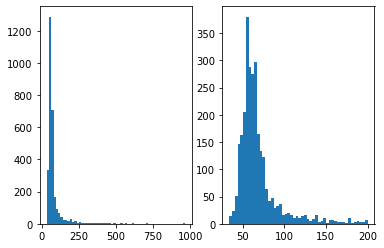

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2)
cluster_nums = real_images_df[real_images_df.cluster_num <= 1000].cluster_num.tolist() # get rid of outliers
cluster_nums_restricted = real_images_df[real_images_df.cluster_num <= 200].cluster_num.tolist() # more restricted

print("{}% of images with <= 200 clusters.".format((len(cluster_nums_restricted) / real_images_df.shape[0]) * 100))
ax1.hist(cluster_nums, bins=60)

ax2.hist(cluster_nums_restricted, bins=50)
plt.show()

#### How do the outliers look like ?

TypeError: Image data of dtype object cannot be converted to float

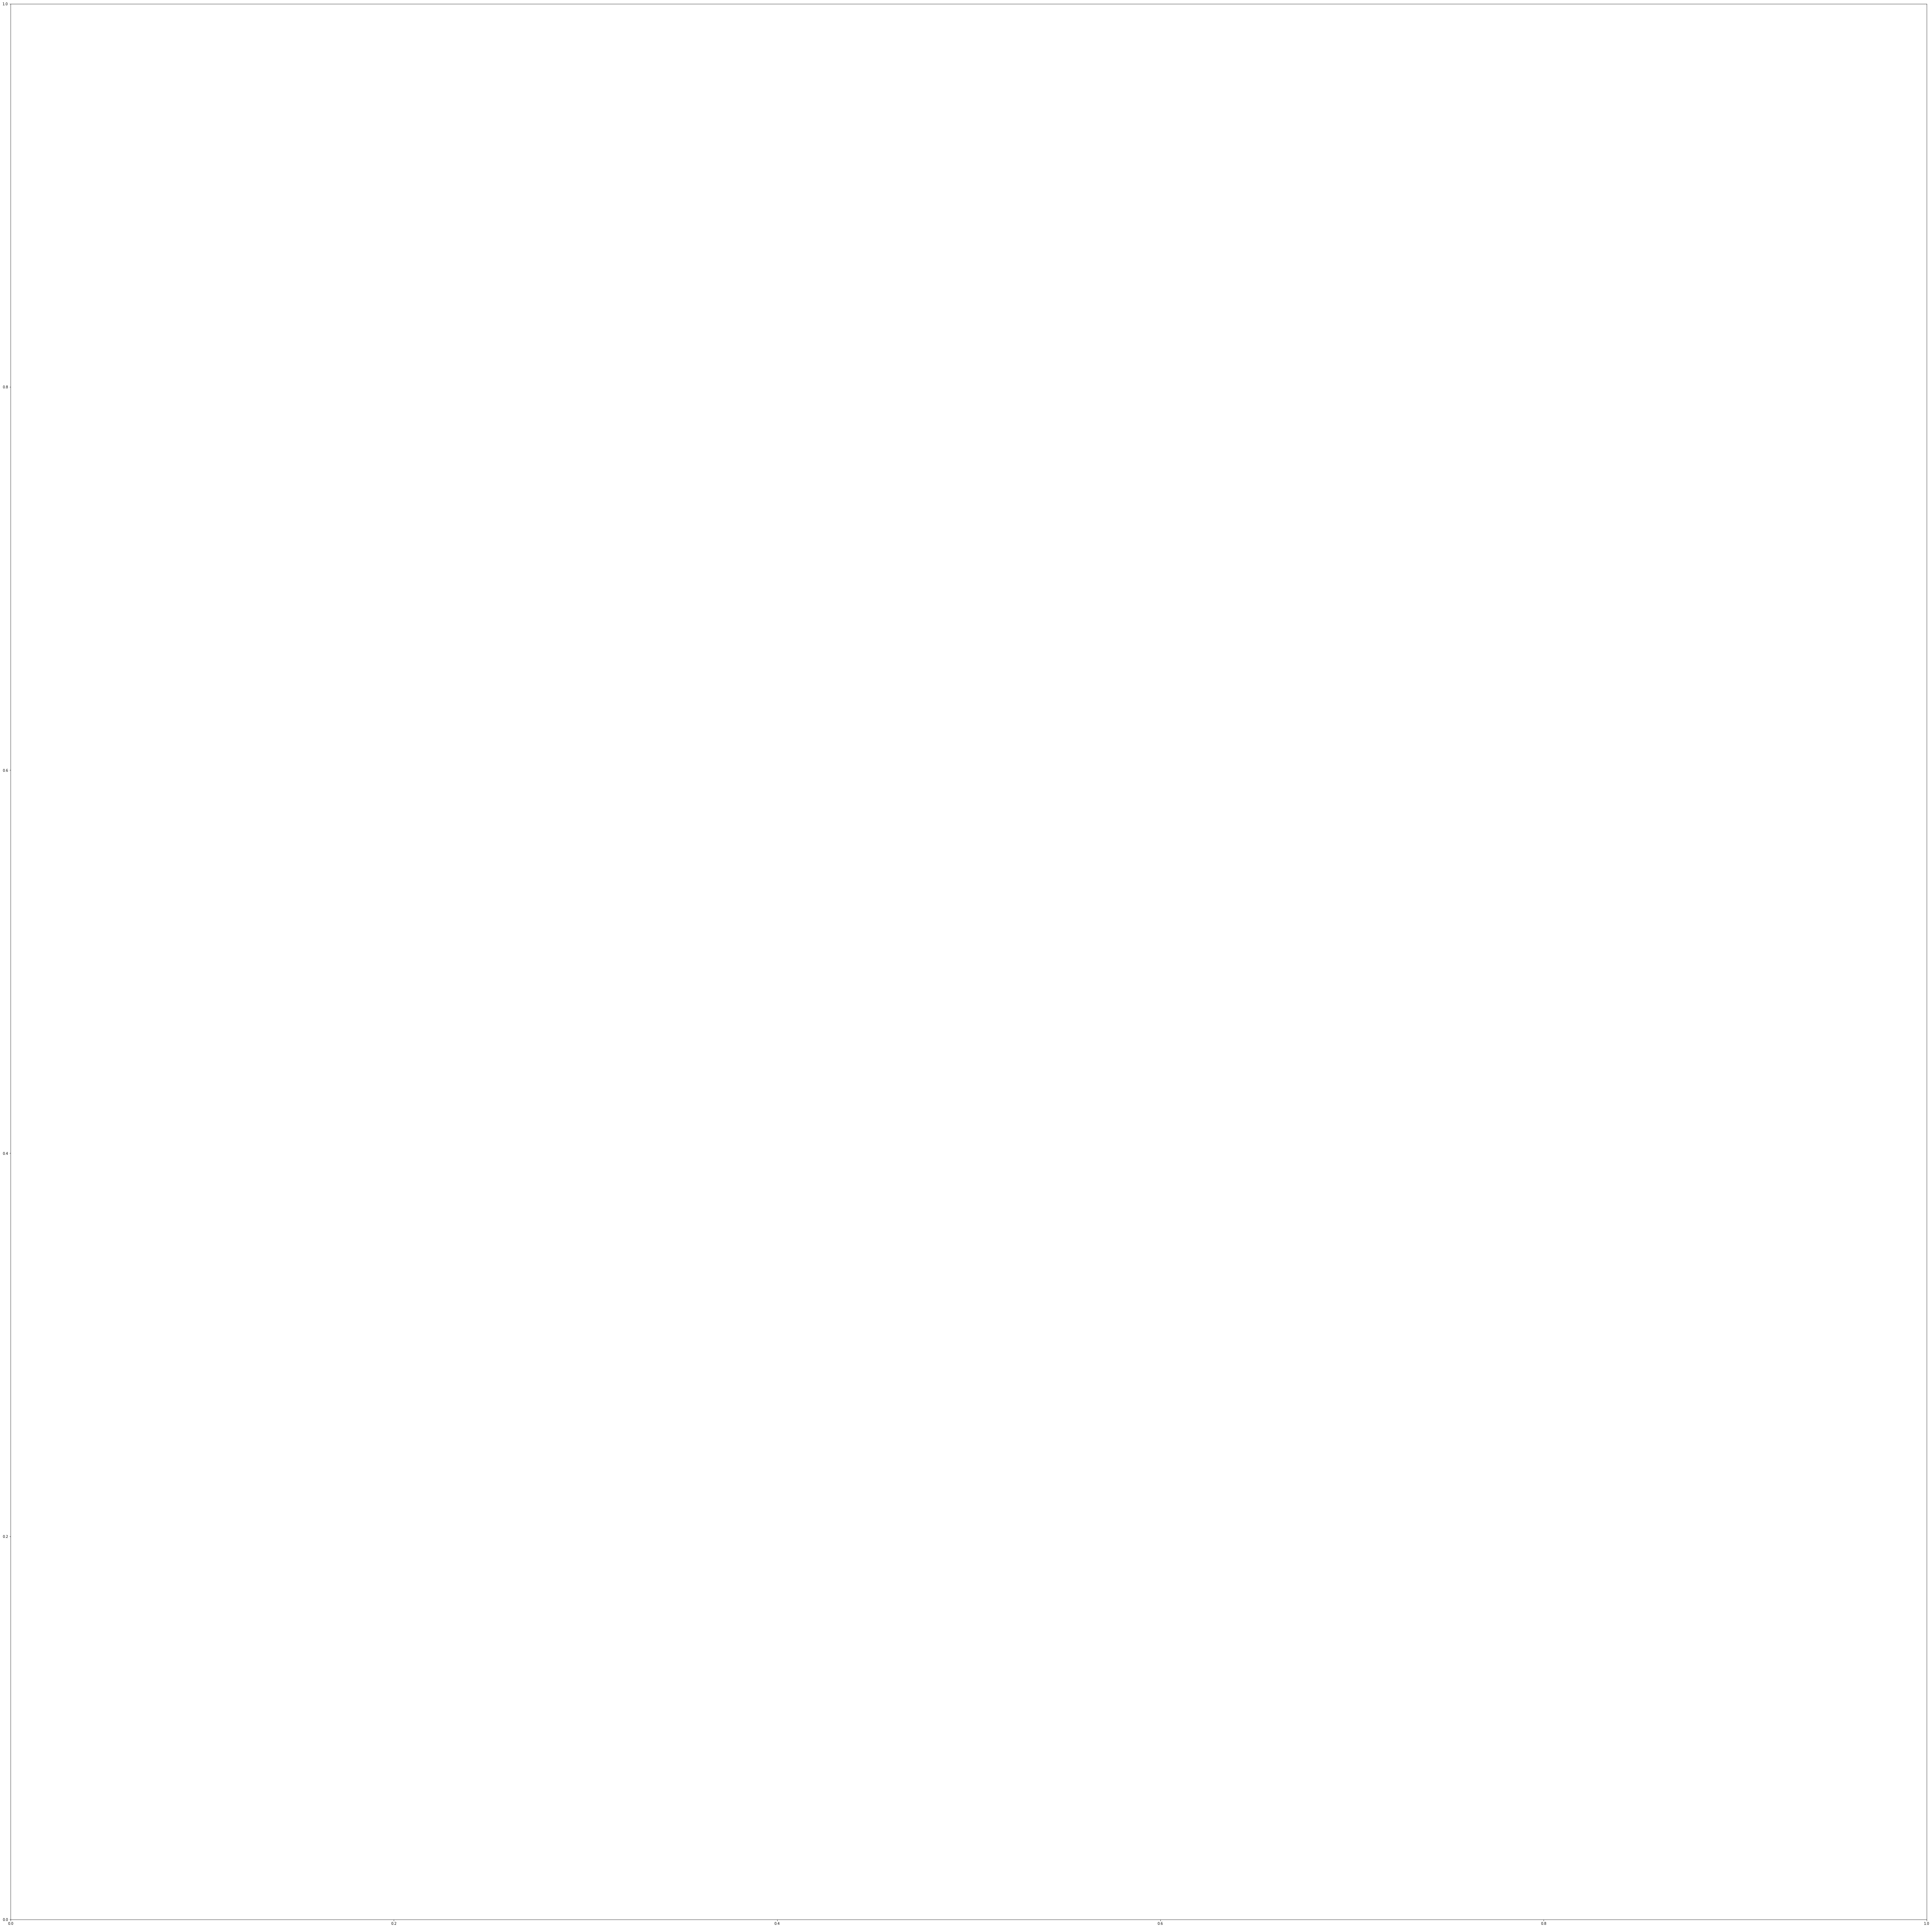

In [11]:
outlier_image_id = real_images_df[real_images_df.cluster_num > 1000].index.tolist()[0]
outlier_img = cv2.imread('../data/scored/{}.png'.format(outlier_image_id))
fig, ax = plt.subplots(figsize=(100, 100))
plt.imshow(outlier_img, cmap='gray')
plt.show()
print(pixel_intensity_histogram(outlier_img))

### Distribution of galaxy size

#### Result 1: A vast  majority of the 'clusters' are actually just a single point

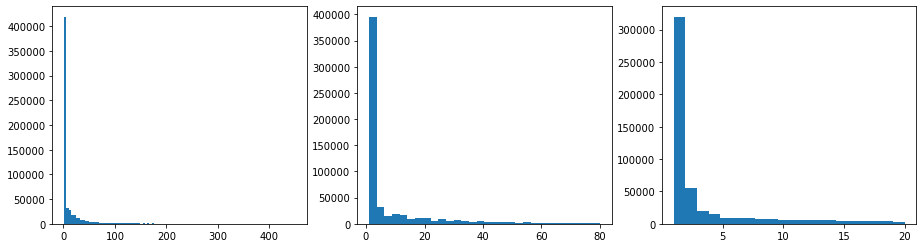

In [12]:
all_galaxy_sizes = list(itertools.chain.from_iterable(real_images_df.cluster_sizes.tolist())) 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# fig.tight_layout()
plt.subplots_adjust(left=8.0, bottom=None, right=10.0, top=None, wspace=None, hspace=None)
ax1.hist(all_galaxy_sizes, bins=100, range=(1, 450))
ax2.hist(all_galaxy_sizes, bins=30, range=(1, 80))
ax3.hist(all_galaxy_sizes, bins=20, range=(1, 20))
plt.show()

In [13]:
Counter(all_galaxy_sizes).most_common(15)

[(1, 319914),
 (2, 56063),
 (3, 19651),
 (4, 14925),
 (5, 8785),
 (6, 8683),
 (7, 8207),
 (8, 7476),
 (9, 7310),
 (10, 6151),
 (12, 5613),
 (13, 5543),
 (14, 5420),
 (11, 5266),
 (16, 4950)]

#### Result 2: Most of the single-point clusters are of intensity of only 1
Are these points just noise or distant galaxies ??

In [14]:
all_peak_intensities = np.array(list(itertools.chain.from_iterable(real_images_df.cluster_peak_intensities.tolist()))) 
all_galaxy_sizes = np.array(all_galaxy_sizes)
single_points_galaxy_indices = all_galaxy_sizes == 1

Counter(all_peak_intensities[single_points_galaxy_indices]).most_common(10)

[(1, 212001), (2, 84981), (3, 22911), (4, 21)]